In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [29]:
image_path = '/content/marcogionfriddo.jpeg'

In [30]:
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [31]:
# i valori 200, 130 sono dei valori da ottimizzare il più possibile.
def binarization(image_rgb, mean_thresh=127):

  gray_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

  mean_intensity = np.mean(gray_image)

  if mean_intensity > mean_thresh:
    # sfondo chiaro, testo scuro -> testo bianco su sfondo nero
    _, binary = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)
  else:
    # sfondo scuro, testo chiaro -> testo bianco su sfondo nero
    _, binary = cv2.threshold(gray_image, 130, 255, cv2.THRESH_BINARY)

  return binary

In [32]:
def segment_and_merge_characters(binary_img, orig_img=None, min_area=0, merge_threshold=0.5, vertical_gap_ratio=1.5):

    # Esegui connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img)

    # Copia dell'immagine originale o scala di grigi per il disegno
    if orig_img is None:
        draw_img = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)
    else:
        draw_img = orig_img.copy()

    bboxes = []
    for label in range(1, num_labels):
        x, y, w, h, area = stats[label]
        if area >= min_area:
            bboxes.append((x, y, w, h))

    # Ordina le bbox da sinistra a destra
    bboxes.sort(key=lambda box: box[0])

    merged = [False] * len(bboxes)
    new_bboxes = []

    for i in range(len(bboxes)):
        if merged[i]:
            continue
        x1, y1, w1, h1 = bboxes[i]
        merged_box = [x1, y1, x1 + w1, y1 + h1]  # [x_min, y_min, x_max, y_max]

        for j in range(i + 1, len(bboxes)):
            if merged[j]:
                continue
            x2, y2, w2, h2 = bboxes[j]

            # Calcolo sovrapposizione proiezioni verticali (asse x)
            x_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
            min_width = min(w1, w2)
            overlap_ratio = x_overlap / min_width if min_width > 0 else 0

            # Distanza verticale tra i bounding box
            vertical_distance = abs(y2 - (y1 + h1)) if y2 > y1 else abs(y1 - (y2 + h2))
            max_height = max(h1, h2)

            if overlap_ratio >= merge_threshold and vertical_distance <= vertical_gap_ratio * max_height:
                # Unione delle bbox
                merged_box[0] = min(merged_box[0], x2)
                merged_box[1] = min(merged_box[1], y2)
                merged_box[2] = max(merged_box[2], x2 + w2)
                merged_box[3] = max(merged_box[3], y2 + h2)
                merged[j] = True

        new_bboxes.append((
            merged_box[0],
            merged_box[1],
            merged_box[2] - merged_box[0],
            merged_box[3] - merged_box[1]
        ))

    # Disegna le bounding box sull'immagine
    for x, y, w, h in new_bboxes:
        cv2.rectangle(draw_img, (x, y), (x + w, y + h), (0, 255, 0), 0)

    return new_bboxes, draw_img

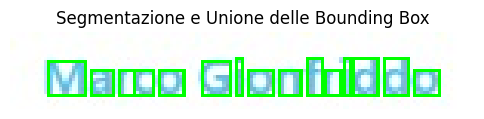

In [33]:
binary = binarization(image_rgb)
bboxes, boxed_img = segment_and_merge_characters(binary, orig_img=image_rgb)

plt.figure(figsize=(6, 6))
plt.imshow(boxed_img)
plt.title('Segmentazione e Unione delle Bounding Box')
plt.axis('off')
plt.show()